# **Khởi tạo**

**Import thư viện**

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Dropout, LSTM, Dense, Flatten, Reshape
import os

**Đọc và xử lý dữ liệu**

In [28]:
def read_file(file_name):
    # Đọc dữ liệu từ file CSV
    data = pd.read_csv(file_name)

    # Chuyển cột 'Date' thành kiểu dữ liệu datetime và đặt làm index
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    # Chuyển đổi các cột khác sang dạng số nếu cần thiết
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    data = data[['Price']]

    # Sắp xếp dữ liệu theo thời gian từ quá khứ đến hiện tại
    data.sort_index(inplace=True)
    data = data.reset_index()['Price']

    return data

**Xây dựng mô hình**

In [29]:
# Hàm tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [30]:
# Hàm Create Dataset
def create_dataset(dataset, seq_size=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-seq_size-1):
        window = dataset[i:(i+seq_size), 0]
        dataX.append(window)
        dataY.append(dataset[i + seq_size, 0])
    return np.array(dataX), np.array(dataY)

In [31]:
# Predict the next 30, 60, and 90 days
def predict_future(days, model, seq_size, test_data, scaler):
    x_input = test_data[-seq_size:].reshape(1, -1)
    temp_input = list(x_input[0])
    lst_output = []

    while len(lst_output) < days:
        if len(temp_input) > seq_size:
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, seq_size, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
        else:
            x_input = x_input.reshape((1, seq_size, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())
    return scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))


In [32]:
def LSTM_prediction(name, data, train_ratio=0.7):

    # Chuẩn hóa dữ liệu
    scaler = MinMaxScaler(feature_range=(0,1))
    data = scaler.fit_transform(np.array(data).reshape(-1,1))

    # Chia train, test
    train_size = int(train_ratio * len(data))
    test_size = len(data) - train_size
    train_data = data[:train_size]
    test_data = data[train_size:]
    
    # Reshape into X=t,t+1,t+2..t+99 and Y=t+100
    time_step = 100
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)
    
    # Reshape input to be [samples, time steps, features] which is required for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
  
    # Xây dựng mô hình LSTM
    model=Sequential()
    model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
    model.add(LSTM(50,return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')
    # model.summary()
    
    # Fit mô hình với dữ liệu train
    model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)

    # Dự báo dữ liệu test
    train_predict = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    # Chuẩn hóa dữ liệu y_pred
    train_predict=scaler.inverse_transform(train_predict)
    y_pred=scaler.inverse_transform(y_pred)
    # Chuẩn hóa dữ liệu y_test
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Đánh giá độ chính xác thuật toán bằng RMSE
    test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
    print('Testing RMSE:', test_rmse)

    # Đánh giá độ chính xác thuật toán bằng MAE
    test_mae = mean_absolute_error(y_test, y_pred)
    print('Testing MAE:', test_mae)
    
    # Đánh giá độ chính xác thuật toán bằng MAPE
    test_mape = mean_absolute_percentage_error(y_test, y_pred)
    print('Testing MAPE:', test_mape)

    # Predict future values
    output_30 = predict_future(30, model, time_step, test_data, scaler)
    output_60 = predict_future(60, model, time_step, test_data, scaler)
    output_90 = predict_future(90, model, time_step, test_data, scaler)

    # Plotting the results
    plt.figure(figsize=(14, 8))
    plt.title('LSTM Predictions '+ name)

    # Plot original training data
    plt.plot(scaler.inverse_transform(train_data), label='Train Data')

    # Plot original test data
    test_data_index = pd.RangeIndex(start=train_size, stop=train_size + test_size, step=1)
    plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test Data')

    # Plot predictions
    test_data_index = pd.RangeIndex(start=train_size + time_step, stop=train_size + time_step + len(y_pred), step=1)
    plt.plot(test_data_index, y_pred, label='Predictions')

    # Concatenate predictions for 30, 60, and 90 days
    future_predictions_30 = np.concatenate((y_pred[-1:], output_30), axis=0)
    future_predictions_60 = np.concatenate((y_pred[-1:], output_60), axis=0)
    future_predictions_90 = np.concatenate((y_pred[-1:], output_90), axis=0)

    # Plot future predictions
    future_index_30 = pd.RangeIndex(start=train_size + time_step + len(y_pred) - 1, stop=train_size + time_step + len(y_pred) + 30, step=1)
    future_index_60 = pd.RangeIndex(start=train_size + time_step + len(y_pred) - 1, stop=train_size + time_step + len(y_pred) + 60, step=1)
    future_index_90 = pd.RangeIndex(start=train_size + time_step + len(y_pred) - 1, stop=train_size + time_step + len(y_pred) + 90, step=1)

    plt.plot(future_index_90, future_predictions_90, color='red', label='Next 90 days')
    plt.plot(future_index_60, future_predictions_60, color='purple', label='Next 60 days')
    plt.plot(future_index_30, future_predictions_30, color='black', label='Next 30 days')

    plt.legend()
    plt.show()

# **BIDV**

In [33]:
data = read_file("../Dataset/BID Historical Data.csv")
name = 'BIDV'

**BIDV 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Testing RMSE: 1140.5675677882014
Testing MAE: 943.2506750906992
Testing MAPE: 2.215712208469051


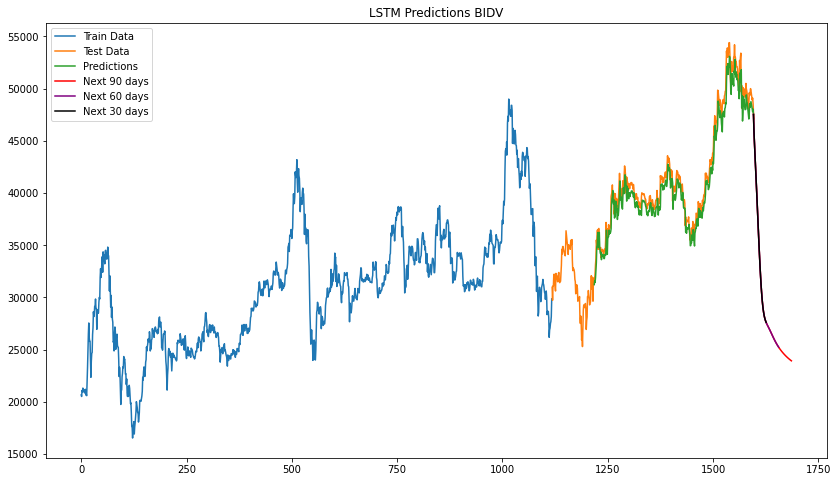

In [34]:
LSTM_prediction(name, data, 0.7)

**BIDV 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Testing RMSE: 863.8935203042885
Testing MAE: 631.6653289098176
Testing MAPE: 1.4107296229672404


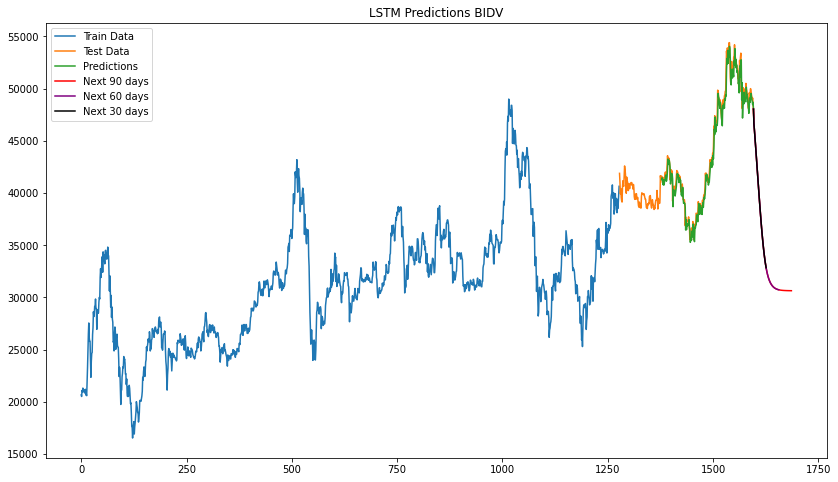

In [35]:
LSTM_prediction(name, data, 0.8)

**BIDV 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Testing RMSE: 991.1276437304225
Testing MAE: 723.5495233050849
Testing MAPE: 1.4183013507975468


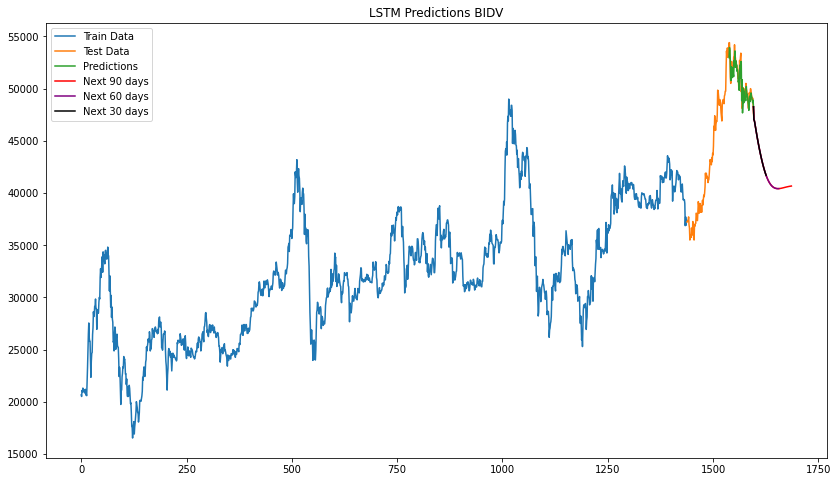

In [36]:
LSTM_prediction(name, data, 0.9)

# **VCB**

In [37]:
data = read_file("../Dataset/VCB Historical Data.csv");
name = 'VCB'

**VCB 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Testing RMSE: 1626.7698818798806
Testing MAE: 1346.1995897922163
Testing MAPE: 1.6365810534307392


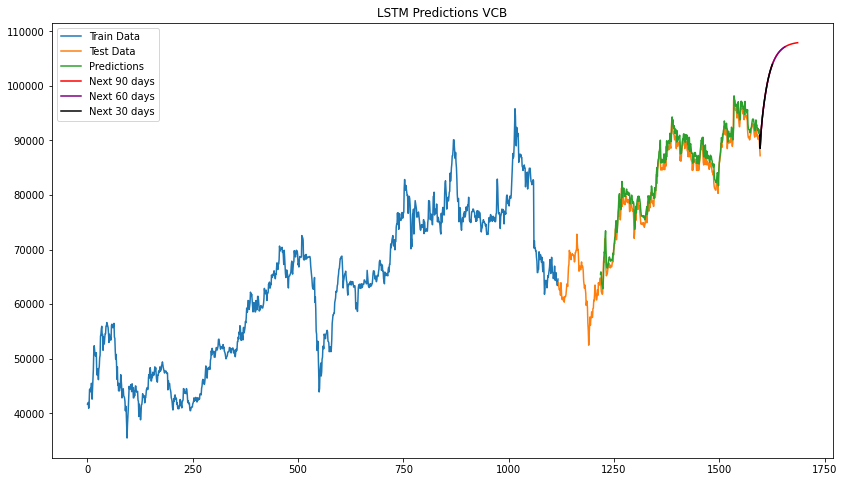

In [38]:
LSTM_prediction(name, data, 0.7)

**VCB 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Testing RMSE: 1170.1718412501793
Testing MAE: 869.4016837899543
Testing MAPE: 0.9696481177480669


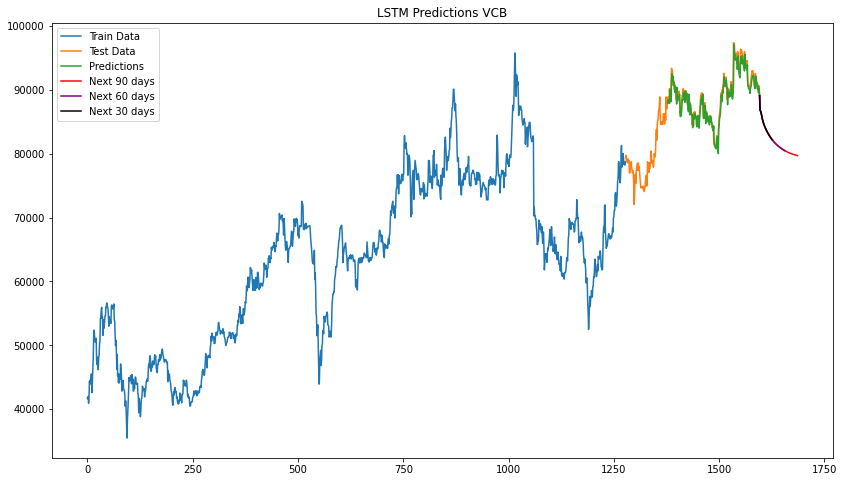

In [39]:
LSTM_prediction(name, data, 0.8)

**VCB 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Testing RMSE: 848.022107492169
Testing MAE: 649.840439618644
Testing MAPE: 0.696394865963759


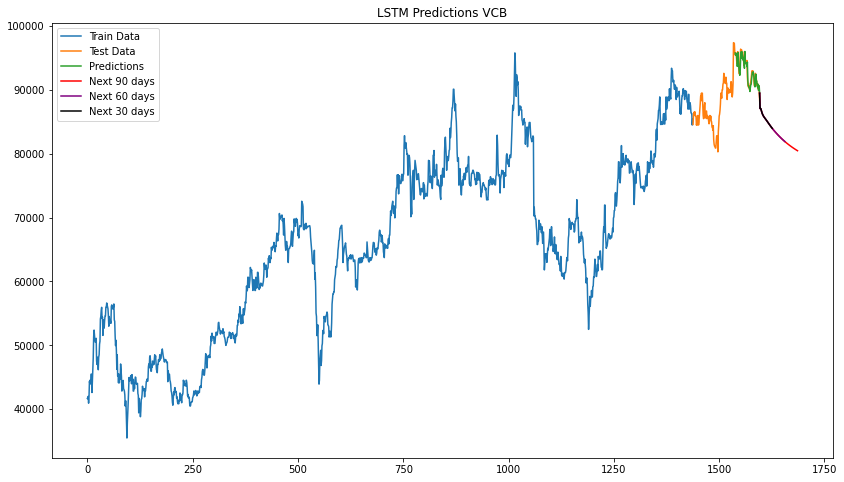

In [40]:
LSTM_prediction(name, data, 0.9)

# **MBB**

In [41]:
data = read_file("../Dataset/MBB Historical Data.csv");
name = 'MBB'

**MBB 7:3**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Testing RMSE: 364.1721319038755
Testing MAE: 262.7031445827836
Testing MAPE: 1.480344403333566


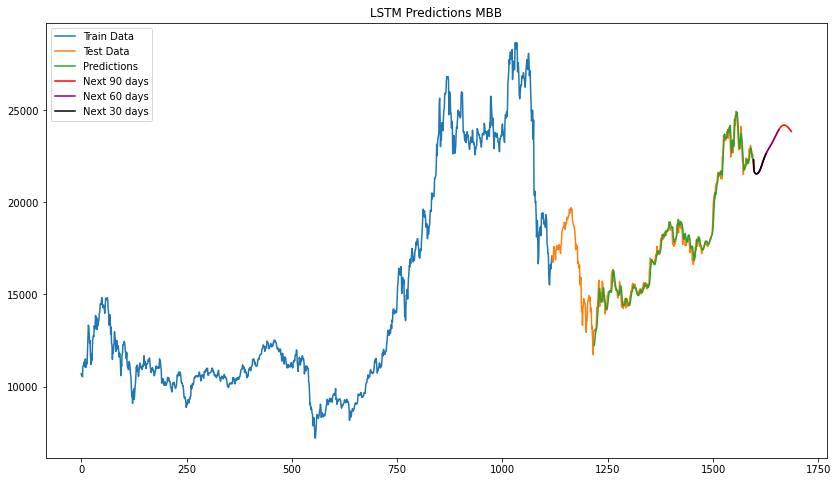

In [42]:
LSTM_prediction(name, data, 0.7)

**MBB 8:2**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Testing RMSE: 309.5242327427643
Testing MAE: 219.66570883276225
Testing MAPE: 1.0753952404209846


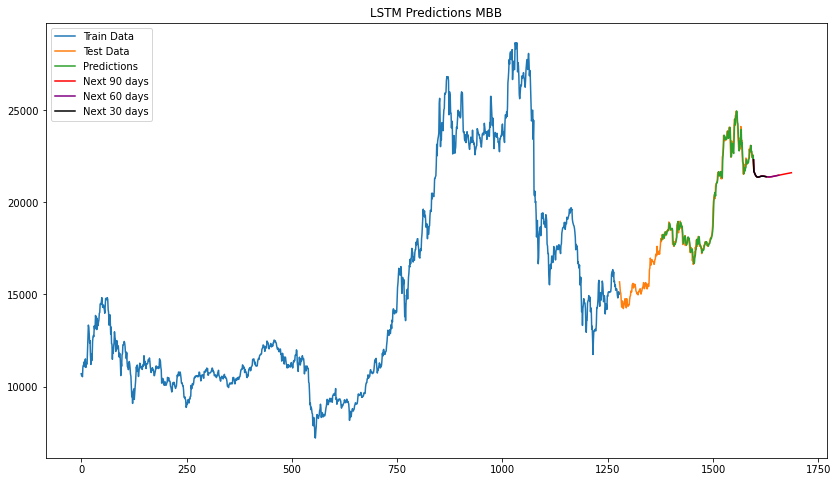

In [43]:
LSTM_prediction(name, data, 0.8)

**MBB 9:1**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Testing RMSE: 424.36764954643485
Testing MAE: 329.6281316207629
Testing MAPE: 1.4214801018552021


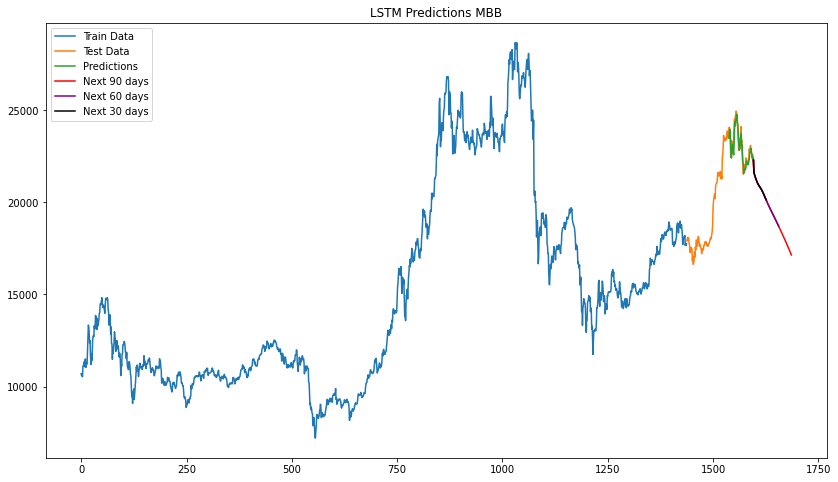

In [44]:
LSTM_prediction(name, data, 0.9)